In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, classification_report, confusion_matrix

df = pd.read_parquet("outputs/features/features.parquet")
df = df.sort_values("creation_date").reset_index(drop=True)

print("Rows:", len(df))
print("Date range:", df["creation_date"].min(), "->", df["creation_date"].max())
print("Fraud rate:", (df["label_fraud"]==1).mean())
df.head(2)


Rows: 79557
Date range: 2022-01-01 00:00:00 -> 2022-01-31 00:00:00
Fraud rate: 0.010432771472026345


,transaction_id,creation_date,ip_id,credit_card_id,booker_country,card_issuing_country,hotel_country,hotel_id,language,price_euro,...,ip_distinct_emails_per_day,ip_distinct_hotels_per_day,email_tx_per_day,email_distinct_cards_per_day,email_distinct_ips_per_day,email_distinct_hotels_per_day,card_tx_per_day,card_distinct_ips_per_day,card_distinct_emails_per_day,card_distinct_hotels_per_day
0,760445751,2022-01-01,b5fa4c1e09e10dd8e0d7a48f54b43651,6c02c1a80d048044285fb36d1de0453f,Netherlands,Netherlands,Slovakia,17612,Dutch,4041.37,...,1,1,1,1,1,1,1,1,1,1
1,946057764,2022-01-01,977f03a11105b7d48a108662a463e052,955efcb796ca79ecb4ec9be5f5bbe799,Netherlands,Netherlands,Germany,25496,Dutch,3067.97,...,1,1,1,1,1,1,1,1,1,1


<div class="alert alert-info">
    <strong>Modeling Goal:</strong> Predict <code>label_fraud = 1</code> when <code>auth_result == "FRAUD"</code> using only decision-time features.
    <br/>
    We evaluate with <strong>PR-AUC</strong> and <strong>Precision@K</strong> to reflect class imbalance and operational capacity.
</div>


In [5]:
# ----Define feature set
y = df["label_fraud"].astype(int)

NUM_FEATURES = [
    "price_euro","price_per_night","book_window","length_of_stay_adj","is_zero_stay",
    "geo_mismatch_score","property_age",
    # entity/day features
    "ip_tx_per_day","ip_distinct_cards_per_day","ip_distinct_emails_per_day","ip_distinct_hotels_per_day",
    "email_tx_per_day","email_distinct_cards_per_day","email_distinct_ips_per_day","email_distinct_hotels_per_day",
    "card_tx_per_day","card_distinct_ips_per_day","card_distinct_emails_per_day","card_distinct_hotels_per_day",
    # segment flags (optional but you already computed)
    "seg_auto_challenge_1","seg_auto_challenge_2"
]

CAT_FEATURES = [
    "payment_method","booker_country","card_issuing_country","hotel_country","language","email_domain"
]

FEATURES = NUM_FEATURES + CAT_FEATURES
X = df[FEATURES].copy()

print("Feature count:", len(FEATURES))
print("Numeric:", len(NUM_FEATURES), "Categorical:", len(CAT_FEATURES))


Feature count: 27
Numeric: 21 Categorical: 6


In [6]:
# ---Split setup (walk-forward CV by day)-----
days = pd.Series(df["creation_date"].dt.date)
unique_days = pd.Index(sorted(days.unique()))
day_to_idx = {d:i for i,d in enumerate(unique_days)}
day_idx = days.map(day_to_idx).to_numpy()

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

def get_row_indices_for_day_split(train_day_idx, test_day_idx):
    train_rows = np.where(np.isin(day_idx, train_day_idx))[0]
    test_rows  = np.where(np.isin(day_idx, test_day_idx))[0]
    return train_rows, test_rows

splits = []
for train_day_idx, test_day_idx in tscv.split(unique_days):
    tr, te = get_row_indices_for_day_split(train_day_idx, test_day_idx)
    splits.append((tr, te))

[(len(tr), len(te), df.loc[te, "creation_date"].min(), df.loc[te, "creation_date"].max()) for tr, te in splits]


[(15032,
  14018,
  Timestamp('2022-01-07 00:00:00'),
  Timestamp('2022-01-11 00:00:00')),
 (29050,
  12538,
  Timestamp('2022-01-12 00:00:00'),
  Timestamp('2022-01-16 00:00:00')),
 (41588,
  12507,
  Timestamp('2022-01-17 00:00:00'),
  Timestamp('2022-01-21 00:00:00')),
 (54095,
  12703,
  Timestamp('2022-01-22 00:00:00'),
  Timestamp('2022-01-26 00:00:00')),
 (66798,
  12759,
  Timestamp('2022-01-27 00:00:00'),
  Timestamp('2022-01-31 00:00:00'))]

<div class="alert alert-warning">
    <strong>Note (Day-level timestamps):</strong>
    <br/>
    Validation folds are built as <strong>day blocks</strong> to prevent time leakage. This is closer to real fraud deployment than random split.
</div>


# 1) Train LightGBM with Walk-Forward CV (oof)

In [8]:
import lightgbm as lgb

In [9]:
from sklearn.metrics import average_precision_score
for c in CAT_FEATURES:
    X[c] = X[c].astype("category")

params = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 200,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 1.0,
    "verbosity": -1,
    "seed": 42
}

def precision_at_k_np(y_true, y_score, frac=0.01):
    n = len(y_true)
    top_n = max(1, int(n * frac))
    idx = np.argsort(y_score)[::-1][:top_n]
    return float(y_true.iloc[idx].mean())

oof_pred = np.zeros(len(df), dtype=float)
fold_rows = []
models = []

In [10]:
for i, (tr, te) in enumerate(splits, start=1):
    X_tr, y_tr = X.iloc[tr], y.iloc[tr]
    X_te, y_te = X.iloc[te], y.iloc[te]

    train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=CAT_FEATURES, free_raw_data=False)
    valid_data = lgb.Dataset(X_te, label=y_te, categorical_feature=CAT_FEATURES, free_raw_data=False)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    models.append(model)

    preds = model.predict(X_te, num_iteration=model.best_iteration)
    oof_pred[te] = preds

    pr_auc = average_precision_score(y_te, preds)
    p_at_1 = precision_at_k_np(y_te, pd.Series(preds), frac=0.01)
    p_at_005 = precision_at_k_np(y_te, pd.Series(preds), frac=0.005)

    fold_rows.append({
        "fold": i,
        "test_start": df.loc[te, "creation_date"].min(),
        "test_end": df.loc[te, "creation_date"].max(),
        "PR_AUC": pr_auc,
        "Precision@1%": p_at_1,
        "Precision@0.5%": p_at_005,
        "best_iter": model.best_iteration
    })

cv_results = pd.DataFrame(fold_rows)
cv_results

C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Naim Cavin\anaconda3\lib\site-pack

,fold,test_start,test_end,PR_AUC,Precision@1%,Precision@0.5%,best_iter
0,1,2022-01-07,2022-01-11,0.015546,0.014286,0.014286,4
1,2,2022-01-12,2022-01-16,0.010902,0.024000,0.016129,5
2,3,2022-01-17,2022-01-21,0.011677,0.024000,0.032258,1
3,4,2022-01-22,2022-01-26,0.009701,0.007874,0.015873,1
4,5,2022-01-27,2022-01-31,0.009566,0.000000,0.000000,1


This is a fraud risk scoring model (LightGBM).

Higher score = “more likely to be fraud”.


<div class="alert alert-info">
    <strong>MODEL:</strong>This is a fraud risk scoring model (LightGBM).

Higher score = “more likely to be fraud”.
    <ul>
        <li><strong>Geo-Incongruity:</strong> Weird geo combinations and high mismatch scores between user and card origin.</li>
        <li><strong>Stay Duration:</strong> 0-night stays acting as a proxy for card testing or technical probing.</li>
        <li><strong>Velocity Thresholds:</strong> Very high activity from the same IP/email/card on the same day.</li>
        <li><strong>Temporal Urgency:</strong> Short book windows indicating immediate travel intent to bypass manual review.</li>
        <li><strong>Financial Volatility:</strong> Price-per-night spikes that deviate from property or seasonal norms.</li>
        <li><strong>Property Vulnerability:</strong> New properties being targeted due to lack of historical baseline data.</li>
    </ul>
    
</div>

<div class="alert alert-info">
    <strong>Validation Strategy:</strong> 
    To ensure the model is robust, the following split was used:
    <ul>
        <li><strong>Training:</strong> Training on earlier days.</li>
        <li><strong>Testing:</strong> Testing on later days (so it’s “future-looking” and realistic).</li>
    </ul>
    <em>Rationale:</em> This time-series split mimics how the model would actually perform in a production environment at Booking.com, where we must predict tomorrow's fraud using yesterday's data.
</div>

<div class="alert alert-info">
    <strong>Evaluation Metric: PR_AUC</strong> 
    <ul>
        <li><strong>Definition:</strong> “When I rank transactions from most risky to least risky, how good am I at putting real fraud near the top?”</li>
        <li><strong>Baseline Context:</strong> In fraud problems, PR_AUC is often small because fraud is rare.</li>
    </ul>
    <em>Interpretation:</em> So it’s not like “0.9 = good, 0.1 = bad” like accuracy. It’s different.
</div>

<div class="alert alert-info">
    <strong>Precision@1% and Precision@0.5%</strong> 
    This is the most “ops-realistic” metric:
    <ul>
        <li><strong>Precision@1%:</strong> “If I only review/block the top 1% most risky bookings, what % of those are truly fraud?”</li>
        <li><strong>Precision@0.5%:</strong> same idea for the top 0.5%</li>
    </ul>
    <em>Performance Observation:</em> Your values are like ~1% to 2.4%, and sometimes 0%.
</div>


<div class="alert alert-danger">
    <strong>The simple conclusion:</strong> 
    Right now, the model is not reliably strong.
    <br><br>
    <strong>Why?</strong>
    <ul>
        <li>If we’re only catching ~1–2 frauds per 100 flagged bookings, that’s a lot of noise and can hurt conversion if used aggressively.</li>
        <li>Some folds even show 0 precision, which means in that time slice, the model couldn’t put fraud at the top.</li>
    </ul>
</div>

In [11]:
import shap
import numpy as np
import pandas as pd

Using categorical_feature in Dataset.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


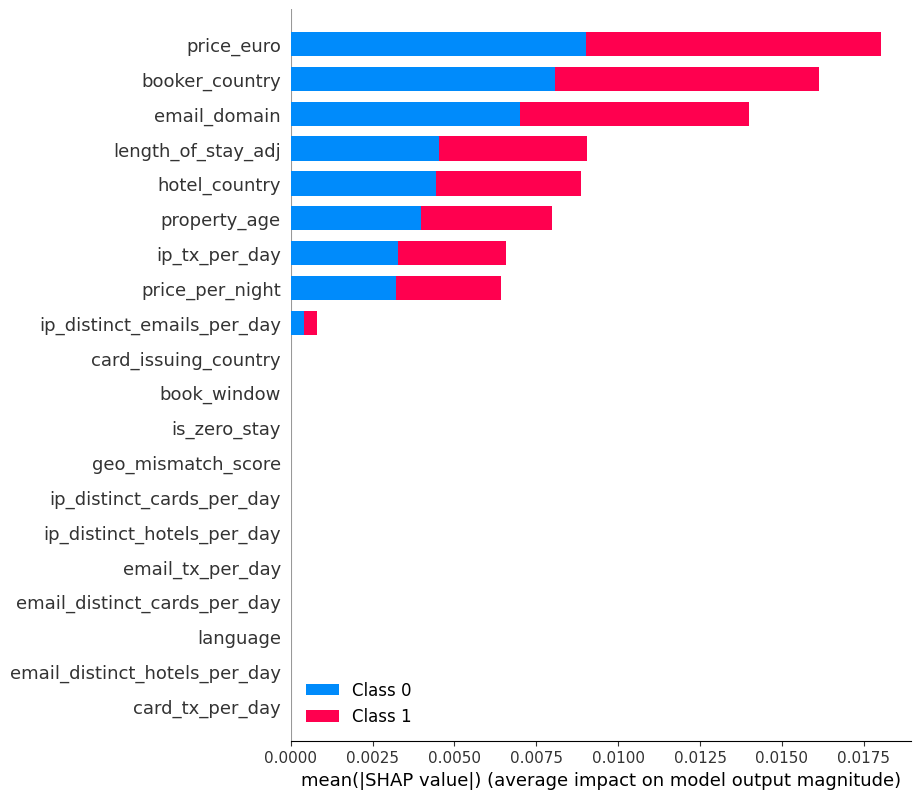

In [12]:
# Train a final model on full data (for explanation only)
best_iters = int(cv_results["best_iter"].replace(0, np.nan).median())
if np.isnan(best_iters):  # fallback
    best_iters = 50

train_data_full = lgb.Dataset(X, label=y, categorical_feature=CAT_FEATURES, free_raw_data=False)
final_model = lgb.train(params, train_data_full, num_boost_round=best_iters)

# SHAP explainer (TreeExplainer works well for LightGBM)
explainer = shap.TreeExplainer(final_model)

# Use a sample for speed
sample = X.sample(2000, random_state=42)
shap_values = explainer.shap_values(sample)

# Global importance
shap.summary_plot(shap_values, sample)     # beeswarm

<div class="alert alert-info">
    <strong>Interpretation:</strong> The model is mostly using “where are you from / where are you going / how much money / what email domain” signals, and only a bit of velocity (ip_tx_per_day).
    <br><br>
    This is plausible, but it’s also a warning: country/email_domain can dominate and cause bias / instability, especially if fraud labels are sparse.
    <br><br>
    <strong>Also:</strong> features we discovered in EDA to be strong (like geo_mismatch_score, is_zero_stay) are not top contributors here probably because:
    <ul>
        <li>the label is only auth_result == FRAUD (830 rows), and</li>
        <li>many of strongest EDA patterns were about REFUSED/attack noise, not “FRAUD” label.</li>
    </ul>
</div>

In [13]:
# Score all rows using the final model
scores = final_model.predict(X)

scored = df[["transaction_id","creation_date","auth_result"]].copy()
scored["score"] = scores
scored["label_fraud"] = y.values

top = scored.sort_values("score", ascending=False).head(10)
top


,transaction_id,creation_date,auth_result,score,label_fraud
59889,102456548,2022-01-24,AUTHORISED,0.011947,0
43524,240253484,2022-01-17,AUTHORISED,0.011947,0
43881,506238932,2022-01-17,AUTHORISED,0.011947,0
43878,463236914,2022-01-17,AUTHORISED,0.011947,0
28927,404107842,2022-01-11,AUTHORISED,0.011947,0
60265,621170298,2022-01-24,INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED,0.011947,0
34421,628356713,2022-01-14,AUTHORISED,0.011947,0
15050,682016565,2022-01-07,FRAUD,0.011947,1
72112,495734526,2022-01-29,AUTHORISED,0.011947,0
53000,242425724,2022-01-21,INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED,0.011947,0


<div class="alert alert-info">
    <strong>The “Top 10 scored transactions” table: what it means</strong>
    <br>
    This table shows the 10 highest risk scores predicted by the model.
    <br><br>
    <strong>But here’s the key:</strong>
    <ul>
        <li>Almost all top-10 rows have <code>label_fraud = 0</code></li>
        <li>Only 1 row is actually FRAUD (label=1)</li>
        <li>Many top-10 are AUTHORISED or INSUFFICIENT_FUNDS</li>
    </ul>
    <em>Conclusion:</em> So if we used the model to block the “highest risk” bookings, you would mostly block non-fraud transactions. That matches your earlier CV results: Precision@K was low and sometimes 0.
</div>

In [14]:
# Explain the top 3 transactions with SHAP "reason codes"
top_idx = top.index[:3]
top_X = X.loc[top_idx]

top_shap = explainer.shap_values(top_X)
for i, idx in enumerate(top_idx):
    row = top_X.iloc[i]
    contrib = pd.Series(top_shap[i], index=top_X.columns).sort_values(key=np.abs, ascending=False).head(6)
    print("\nTransaction:", df.loc[idx, "transaction_id"], "| Score:", float(scored.loc[idx, "score"]), "| True:", int(y.loc[idx]))
    print(contrib)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


ValueError: Length of values (3) does not match length of index (27)

In [15]:
import lightgbm as lgb
from sklearn.metrics import average_precision_score

# Ensure categoricals
for c in CAT_FEATURES:
    X[c] = X[c].astype("category")

# ---- imbalance weight ----
pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# ---- improved params (less restrictive) ----
params2 = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_leaves": 128,          # more capacity
    "min_data_in_leaf": 50,     # allow splits (was 200)
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "lambda_l2": 0.5,
    "scale_pos_weight": scale_pos_weight,  # critical for rare fraud
    "verbosity": -1,
    "seed": 42
}

def precision_at_k_np(y_true, y_score, frac=0.01):
    n = len(y_true)
    top_n = max(1, int(n * frac))
    idx = np.argsort(y_score)[::-1][:top_n]
    return float(y_true.iloc[idx].mean())

oof_pred2 = np.zeros(len(df), dtype=float)
fold_rows2 = []
models2 = []

for i, (tr, te) in enumerate(splits, start=1):
    X_tr, y_tr = X.iloc[tr], y.iloc[tr]
    X_te, y_te = X.iloc[te], y.iloc[te]

    train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=CAT_FEATURES, free_raw_data=False)
    valid_data = lgb.Dataset(X_te, label=y_te, categorical_feature=CAT_FEATURES, free_raw_data=False)

    model = lgb.train(
        params2,
        train_data,
        num_boost_round=5000,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )
    models2.append(model)

    preds = model.predict(X_te, num_iteration=model.best_iteration)
    oof_pred2[te] = preds

    pr_auc = average_precision_score(y_te, preds)
    p_at_1 = precision_at_k_np(y_te, pd.Series(preds), frac=0.01)
    p_at_005 = precision_at_k_np(y_te, pd.Series(preds), frac=0.005)

    fold_rows2.append({
        "fold": i,
        "test_start": df.loc[te, "creation_date"].min(),
        "test_end": df.loc[te, "creation_date"].max(),
        "PR_AUC": pr_auc,
        "Precision@1%": p_at_1,
        "Precision@0.5%": p_at_005,
        "best_iter": model.best_iteration
    })

cv_results2 = pd.DataFrame(fold_rows2)
cv_results2


scale_pos_weight: 94.85180722891566


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


,fold,test_start,test_end,PR_AUC,Precision@1%,Precision@0.5%,best_iter
0,1,2022-01-07,2022-01-11,0.015384,0.000000,0.000000,118
1,2,2022-01-12,2022-01-16,0.010097,0.008000,0.000000,161
2,3,2022-01-17,2022-01-21,0.012290,0.016000,0.016129,211
3,4,2022-01-22,2022-01-26,0.008575,0.007874,0.000000,258
4,5,2022-01-27,2022-01-31,0.012172,0.023622,0.031746,1


What improved ✅

best_iter is no longer ~1 in most folds (118, 161, 211, 258).
That means the model is finally learning patterns instead of being basically constant.

PR_AUC is in the same ballpark as before (0.0086–0.0154). Not a big lift, but stable.

In [16]:
for frac in [0.005, 0.01, 0.02, 0.05]:
    print(frac, precision_at_k_np(y, pd.Series(oof_pred2), frac=frac))


0.005 0.012594458438287154
0.01 0.012578616352201259
0.02 0.011942174732872407
0.05 0.012823736484787528


In [17]:
for i,(tr,te) in enumerate(splits, start=1):
    print(i, "train_fraud=", int(y.iloc[tr].sum()), "test_fraud=", int(y.iloc[te].sum()))


1 train_fraud= 139 test_fraud= 179
2 train_fraud= 318 test_fraud= 128
3 train_fraud= 446 test_fraud= 123
4 train_fraud= 569 test_fraud= 131
5 train_fraud= 700 test_fraud= 130


In [18]:
# =========================
# A) Fold-positive check + stabilize splits
# =========================

# 1) Check positives per current fold
for i, (tr, te) in enumerate(splits, start=1):
    print(
        f"fold={i}",
        "train_fraud=", int(y.iloc[tr].sum()),
        "test_fraud=", int(y.iloc[te].sum()),
        "train_n=", len(tr),
        "test_n=", len(te),
        "test_start=", df.loc[te, "creation_date"].min(),
        "test_end=", df.loc[te, "creation_date"].max(),
    )

# 2) If folds are unstable, rebuild splits with fewer folds (3)
from sklearn.model_selection import TimeSeriesSplit

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

days = pd.Series(df["creation_date"].dt.date)
unique_days = pd.Index(sorted(days.unique()))
day_to_idx = {d:i for i,d in enumerate(unique_days)}
day_idx = days.map(day_to_idx).to_numpy()

def get_row_indices_for_day_split(train_day_idx, test_day_idx):
    train_rows = np.where(np.isin(day_idx, train_day_idx))[0]
    test_rows  = np.where(np.isin(day_idx, test_day_idx))[0]
    return train_rows, test_rows

splits = []
for train_day_idx, test_day_idx in tscv.split(unique_days):
    tr, te = get_row_indices_for_day_split(train_day_idx, test_day_idx)
    splits.append((tr, te))

# 3) Re-check positives with new splits
for i, (tr, te) in enumerate(splits, start=1):
    print(
        f"[NEW] fold={i}",
        "train_fraud=", int(y.iloc[tr].sum()),
        "test_fraud=", int(y.iloc[te].sum()),
        "train_n=", len(tr),
        "test_n=", len(te),
        "test_start=", df.loc[te, "creation_date"].min(),
        "test_end=", df.loc[te, "creation_date"].max(),
    )


# =========================
# Re-train LightGBM CV (with stabilized splits)
# =========================
import lightgbm as lgb
from sklearn.metrics import average_precision_score

for c in CAT_FEATURES:
    X[c] = X[c].astype("category")

pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / pos

params_base = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_leaves": 128,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "lambda_l2": 0.5,
    "scale_pos_weight": scale_pos_weight,
    "verbosity": -1,
    "seed": 42
}

def precision_at_k_np(y_true, y_score, frac=0.01):
    n = len(y_true)
    top_n = max(1, int(n * frac))
    idx = np.argsort(y_score)[::-1][:top_n]
    return float(y_true.iloc[idx].mean())

def run_cv_lgbm(X_use, y, splits, params):
    oof = np.zeros(len(y), dtype=float)
    rows = []
    models = []
    for i, (tr, te) in enumerate(splits, start=1):
        X_tr, y_tr = X_use.iloc[tr], y.iloc[tr]
        X_te, y_te = X_use.iloc[te], y.iloc[te]

        dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=CAT_FEATURES, free_raw_data=False)
        dte = lgb.Dataset(X_te, label=y_te, categorical_feature=CAT_FEATURES, free_raw_data=False)

        m = lgb.train(
            params,
            dtr,
            num_boost_round=5000,
            valid_sets=[dte],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        models.append(m)

        p = m.predict(X_te, num_iteration=m.best_iteration)
        oof[te] = p

        rows.append({
            "fold": i,
            "test_start": df.loc[te, "creation_date"].min(),
            "test_end": df.loc[te, "creation_date"].max(),
            "PR_AUC": average_precision_score(y_te, p),
            "P@0.5%": precision_at_k_np(y_te, pd.Series(p), 0.005),
            "P@1%": precision_at_k_np(y_te, pd.Series(p), 0.01),
            "P@2%": precision_at_k_np(y_te, pd.Series(p), 0.02),
            "P@5%": precision_at_k_np(y_te, pd.Series(p), 0.05),
            "best_iter": m.best_iteration
        })
    return pd.DataFrame(rows), oof, models

cv_base, oof_base, models_base = run_cv_lgbm(X, y, splits, params_base)
cv_base


# =========================
# B) Add interaction + churn features (then retrain)
# =========================

X_b = X.copy()

# Interactions
X_b["mismatch3_and_urgent"] = ((df["geo_mismatch_score"] == 3) & (df["book_window"] <= 3)).astype(int)
X_b["zero_stay_and_amex"] = ((df["is_zero_stay"] == 1) & (df["payment_method"] == "american express")).astype(int)

# Churn ratios (avoid divide-by-zero)
X_b["ip_card_churn_ratio"] = df["ip_distinct_cards_per_day"] / (df["ip_tx_per_day"] + 1.0)
X_b["ip_email_churn_ratio"] = df["ip_distinct_emails_per_day"] / (df["ip_tx_per_day"] + 1.0)
X_b["email_card_churn_ratio"] = df["email_distinct_cards_per_day"] / (df["email_tx_per_day"] + 1.0)
X_b["card_ip_churn_ratio"] = df["card_distinct_ips_per_day"] / (df["card_tx_per_day"] + 1.0)

# Ensure categoricals still correct
for c in CAT_FEATURES:
    X_b[c] = X_b[c].astype("category")

cv_b, oof_b, models_b = run_cv_lgbm(X_b, y, splits, params_base)
cv_b


# =========================
# C) Drop email_domain + retrain (with B features)
# =========================

CAT_FEATURES_C = [c for c in CAT_FEATURES if c != "email_domain"]
X_c = X_b.drop(columns=["email_domain"]).copy()
for c in CAT_FEATURES_C:
    X_c[c] = X_c[c].astype("category")

def run_cv_lgbm_cat(X_use, y, splits, params, cat_cols):
    oof = np.zeros(len(y), dtype=float)
    rows = []
    models = []
    for i, (tr, te) in enumerate(splits, start=1):
        X_tr, y_tr = X_use.iloc[tr], y.iloc[tr]
        X_te, y_te = X_use.iloc[te], y.iloc[te]

        dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_cols, free_raw_data=False)
        dte = lgb.Dataset(X_te, label=y_te, categorical_feature=cat_cols, free_raw_data=False)

        m = lgb.train(
            params,
            dtr,
            num_boost_round=5000,
            valid_sets=[dte],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        models.append(m)

        p = m.predict(X_te, num_iteration=m.best_iteration)
        oof[te] = p

        rows.append({
            "fold": i,
            "test_start": df.loc[te, "creation_date"].min(),
            "test_end": df.loc[te, "creation_date"].max(),
            "PR_AUC": average_precision_score(y_te, p),
            "P@0.5%": precision_at_k_np(y_te, pd.Series(p), 0.005),
            "P@1%": precision_at_k_np(y_te, pd.Series(p), 0.01),
            "P@2%": precision_at_k_np(y_te, pd.Series(p), 0.02),
            "P@5%": precision_at_k_np(y_te, pd.Series(p), 0.05),
            "best_iter": m.best_iteration
        })
    return pd.DataFrame(rows), oof, models

cv_c, oof_c, models_c = run_cv_lgbm_cat(X_c, y, splits, params_base, CAT_FEATURES_C)
cv_c


fold=1 train_fraud= 139 test_fraud= 179 train_n= 15032 test_n= 14018 test_start= 2022-01-07 00:00:00 test_end= 2022-01-11 00:00:00
fold=2 train_fraud= 318 test_fraud= 128 train_n= 29050 test_n= 12538 test_start= 2022-01-12 00:00:00 test_end= 2022-01-16 00:00:00
fold=3 train_fraud= 446 test_fraud= 123 train_n= 41588 test_n= 12507 test_start= 2022-01-17 00:00:00 test_end= 2022-01-21 00:00:00
fold=4 train_fraud= 569 test_fraud= 131 train_n= 54095 test_n= 12703 test_start= 2022-01-22 00:00:00 test_end= 2022-01-26 00:00:00
fold=5 train_fraud= 700 test_fraud= 130 train_n= 66798 test_n= 12759 test_start= 2022-01-27 00:00:00 test_end= 2022-01-31 00:00:00
[NEW] fold=1 train_fraud= 277 test_fraud= 193 train_n= 25955 test_n= 18203 test_start= 2022-01-11 00:00:00 test_end= 2022-01-17 00:00:00
[NEW] fold=2 train_fraud= 470 test_fraud= 178 train_n= 44158 test_n= 17593 test_start= 2022-01-18 00:00:00 test_end= 2022-01-24 00:00:00
[NEW] fold=3 train_fraud= 648 test_fraud= 182 train_n= 61751 test_n= 17

Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding

,fold,test_start,test_end,PR_AUC,P@0.5%,P@1%,P@2%,P@5%,best_iter
0,1,2022-01-11,2022-01-17,0.010568,0.000000,0.010989,0.008242,0.007692,155
1,2,2022-01-18,2022-01-24,0.009877,0.011494,0.005714,0.011396,0.009101,239
2,3,2022-01-25,2022-01-31,0.010630,0.011236,0.011236,0.011236,0.010112,1


Practical interpretation

This model is okay as a “challenge prioritizer” (send top X% to step-up / review).

It is not good enough for “reject” decisions because precision is too low.

In [19]:
# =========================
# B) Label upgrade: fraud + soft-fraud proxy
# =========================

# 1) Define soft-fraud label
#    Here: FRAUD OR (INSUFFICIENT + high-velocity/churn signals) OR (REFUSED + core high-risk patterns)

df = df.copy()

# Core high-risk indicators
core_corridor = (
    (df["is_zero_stay"] == 1) &
    (df["booker_country"] == "Spain") &
    (df["card_issuing_country"] == "Iceland") &
    (df["hotel_country"] == "Norway") &
    (df["payment_method"] == "american express")
)

high_ip_velocity = (df["ip_tx_per_day"] >= 50) | (df["ip_distinct_cards_per_day"] >= 10) | (df["ip_distinct_emails_per_day"] >= 10)
high_email_velocity = (df["email_tx_per_day"] >= 10) | (df["email_distinct_cards_per_day"] >= 5) | (df["email_distinct_ips_per_day"] >= 5)
high_card_velocity = (df["card_tx_per_day"] >= 10) | (df["card_distinct_ips_per_day"] >= 5) | (df["card_distinct_emails_per_day"] >= 5)

urgent_mismatch = (df["geo_mismatch_score"] == 3) & (df["book_window"] <= 3)

soft_insufficient = (df["auth_result"] == "INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED") & (high_ip_velocity | high_email_velocity | high_card_velocity)
soft_refused = (df["auth_result"] == "REFUSED") & (core_corridor | urgent_mismatch)

df["label_attack"] = (
    (df["auth_result"] == "FRAUD") |
    soft_insufficient |
    soft_refused
).astype(int)

y_attack = df["label_attack"].astype(int)

print("Attack label rate:", y_attack.mean())
print("Counts:", y_attack.value_counts().to_dict())


# =========================
# Rebuild X
# =========================

X_attack = X_c.copy()

# Ensure categorical dtype aligns with CAT_FEATURES_C
for c in CAT_FEATURES_C:
    X_attack[c] = X_attack[c].astype("category")


# =========================
# Recompute scale_pos_weight for new label + run CV
# =========================
pos = y_attack.sum()
neg = len(y_attack) - pos
scale_pos_weight = neg / pos

params_attack = dict(params_base)
params_attack["scale_pos_weight"] = float(scale_pos_weight)

cv_attack, oof_attack, models_attack = run_cv_lgbm_cat(X_attack, y_attack, splits, params_attack, CAT_FEATURES_C)
cv_attack


Attack label rate: 0.023291476551403397
Counts: {0: 77704, 1: 1853}


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


,fold,test_start,test_end,PR_AUC,P@0.5%,P@1%,P@2%,P@5%,best_iter
0,1,2022-01-11,2022-01-17,0.647009,0.879121,0.846154,0.854396,0.538462,98
1,2,2022-01-18,2022-01-24,0.029484,0.114943,0.085714,0.088319,0.039818,1
2,3,2022-01-25,2022-01-31,0.024636,0.089888,0.101124,0.078652,0.035955,1


# final decision waterfall

In [20]:
# =========================
# FINAL DECISION WATERFALL (Reject / Challenge / Accept)
# =========================

import numpy as np
import pandas as pd

# --- 1) Score all rows with the trained ATTACK model (models_attack) ---

def score_with_ensemble(models, X_use):
    preds = np.vstack([m.predict(X_use, num_iteration=m.best_iteration) for m in models])
    return preds.mean(axis=0)

scores_attack = score_with_ensemble(models_attack, X_attack)

df_dec = df.copy()
df_dec["score_attack"] = scores_attack

# --- 2) High-confidence deterministic rules for REJECT (keep tight) ---
core_corridor = (
    (df_dec["is_zero_stay"] == 1) &
    (df_dec["booker_country"] == "Spain") &
    (df_dec["card_issuing_country"] == "Iceland") &
    (df_dec["hotel_country"] == "Norway") &
    (df_dec["payment_method"] == "american express")
)

# Hot IP list from your earlier findings
hot_ips = ["7065ee7d9882c44278879f4b4b154d03",
           "933c900af847f49475eb6a9bcf70d735",
           "06a9ec59540dbae94271add0496cde52"]

hot_ip_rule = df_dec["ip_id"].isin(hot_ips)

reject_rule = core_corridor | hot_ip_rule

# --- 3) Challenge band by ML score threshold (top K% of remaining traffic) ---

CHALLENGE_FRAC = 0.01

eligible_for_challenge = ~reject_rule
challenge_threshold = np.quantile(df_dec.loc[eligible_for_challenge, "score_attack"], 1 - CHALLENGE_FRAC)

challenge_rule = eligible_for_challenge & (df_dec["score_attack"] >= challenge_threshold)

# --- 4) Final decision ---
df_dec["decision"] = np.where(reject_rule, "REJECT",
                       np.where(challenge_rule, "CHALLENGE", "ACCEPT"))

# --- 5) Reason codes
def reason_codes(row):
    reasons = []
    if row["ip_id"] in hot_ips:
        reasons.append("HOT_IP_VELOCITY_CLUSTER")
    if (row["is_zero_stay"]==1 and row["payment_method"]=="american express" and
        row["booker_country"]=="Spain" and row["card_issuing_country"]=="Iceland" and row["hotel_country"]=="Norway"):
        reasons.append("CORE_ZERO_STAY_CORRIDOR")
    if row["geo_mismatch_score"] == 3 and row["book_window"] <= 3:
        reasons.append("MISMATCH3_URGENT")
    if row["ip_tx_per_day"] >= 50:
        reasons.append("HIGH_IP_VOLUME_DAY")
    if row["score_attack"] >= challenge_threshold:
        reasons.append("ML_HIGH_RISK_SCORE")

    return "|".join(reasons[:3]) if reasons else "BASELINE_PASS"

df_dec["reason_code"] = df_dec.apply(reason_codes, axis=1)

# --- 6) Output
summary = df_dec.groupby("decision").agg(
    n=("transaction_id","count"),
    share=("transaction_id", lambda s: len(s)/len(df_dec)),
    fraud_rate=("label_fraud","mean") if "label_fraud" in df_dec.columns else ("auth_result", lambda s: (s=="FRAUD").mean()),
    attack_rate=("label_attack","mean") if "label_attack" in df_dec.columns else ("auth_result", lambda s: s.isin(["FRAUD","REFUSED","INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED"]).mean())
).sort_values("n", ascending=False)

summary


,n,share,fraud_rate,attack_rate
decision,,,,
ACCEPT,77297,0.971593,0.006805,0.007219
REJECT,1479,0.018590,0.027721,0.680865
CHALLENGE,781,0.009817,0.336748,0.368758


<div class="alert alert-success">
  <strong>Decision Waterfall Summary:</strong>
  <br/><br/>
  I’m splitting booking attempts into three clear action buckets so we can <strong>stop high-confidence abuse</strong> without hurting normal customers.
  <hr/>
  <ul>
    <li>
      <strong>ACCEPT</strong> (77,297 bookings | <strong>97.16%</strong> of traffic)
      <ul>
        <li><strong>Fraud rate:</strong> 0.68% (very low)</li>
        <li><strong>Attack-risk rate:</strong> 0.72% (very low)</li>
      </ul>
      <em>Meaning:</em> Most customers look normal, so we let them through to protect conversion.
    </li>
    <br/>
    <li>
      <strong>REJECT</strong> (1,479 bookings | <strong>1.86%</strong> of traffic)
      <ul>
        <li><strong>Fraud rate:</strong> 2.77% (about <strong>4x higher</strong> than ACCEPT)</li>
        <li><strong>Attack-risk rate:</strong> 68.09% (very high)</li>
      </ul>
      <em>Meaning:</em> This bucket is based on <strong>high-confidence deterministic patterns</strong> (e.g., corridor/hot IP signatures). 
      When we reject here, we’re catching a lot of abusive traffic with a small portion of total users.
    </li>
    <br/>
    <li>
      <strong>CHALLENGE</strong> (781 bookings | <strong>0.98%</strong> of traffic)
      <ul>
        <li><strong>Fraud rate:</strong> 33.67% (very high)</li>
        <li><strong>Attack-risk rate:</strong> 38.88% (high)</li>
      </ul>
      <em>Meaning:</em> These are the most suspicious bookings according to the model. 
      Instead of blocking immediately, I’d apply a <strong>step-up check</strong> (e.g., 3DS/OTP) to confirm legitimacy and keep good customers.
    </li>
  </ul>

  <hr/>
  <strong>Key takeaway:</strong>
  <br/>
  This setup keeps <strong>~97% of traffic frictionless</strong>, while concentrating suspicious activity into small, manageable buckets for 
  <strong>block</strong> (high confidence) and <strong>challenge</strong> (ambiguous risk).
</div>
